# Lascar

There are hundreds of papers covering all aspects of side-channel analysis.
In contrast only a few frameworks exist which are really able to perform the described analysis in a performant way.


## Why not ChipWhisperer?

ChipWhisperer aims primarily educational purposes. Thus, most methods and computations could be programmed more efficient but maybe less readable.
SecureC tries to close a part of that gap by providing efficient computations but focusing on descriptive visualizations.

## Why Lascar?

When it comes to "real" side-channel analysis the author favours [Lascar](https://github.com/Ledger-Donjon/lascar) with the following reasons:

- High performance
- Well structured and documented code
- Easy start due to good examples
- Citations given for the methods of analysis


## Main aspects of lascar

While lascar's tutorial and the examples provide a comprehensive entry point the main concepts are demonstrated here to make the subsequent analysis understandable.

In [1]:
import lascar

### Container

In [16]:
import sys
print(sys.modules['lascar.container'].__doc__)


container is the module containing all classes and functions dealing with Side channel data storage.
Various format, mechanisms to read, write, acquire, simulate side channel data.



We will mainly use the following container:

In [19]:
lascar.TraceBatchContainer

lascar.container.container.TraceBatchContainer

As described [here](https://github.com/Ledger-Donjon/lascar/blob/master/tutorial/01-discovering-containers.py) it takes to items:


A side-channel trace (Trace in lascar), is a couple of two items:
- The first item is "leakage" and represents the side-channel observable
- The second item is "value" and represents the handled values during the observation of "leakage".
The only restriction here is that "leakage" and "data" must be numpy.arrays of any shape.
trace = (leakage, value) where leakage and value are numpy.arrays
The __str__ method of Trace displays the shape and dtype for both leakage and value.

### Engine

The most important concept is `Engine`. It performs the actual analysis.

In [21]:
print(lascar.Engine.__doc__)


    Engine is an abstract class whose role is to handle TraceBatches from a Session.

    Any class inheriting from Engine must implemement at least 3 methods:
        - _initialize(): called by the Session once before processing batchs
        - _update(batch): called each time the Session has a TraceBatch to process
        - _finalize(): used to deliver the result of the Engine
        - _clean(): used to clean Engine, ie: erase

    


One example which we will use quite often is `CpaEngine`.

In [22]:
print(lascar.CpaEngine.__doc__)


    CpaEngine is a GuessEngine used to perform Correlation Power Analysis.

    (E. Brier, C. Clavier, and F. Olivier. Correlation Power Analysis with a Leakage
    Model. In M. Joye and J.-J. Quisquater, editors, Cryptographic Hardware and Embedded
    Systems – CHES 2004, volume 3156 of Lecture Notes in Computer Science,
    pages 16–29. Springer, 2004.)

    Given a selection_function on the values under a guess guess (emulating a leakage model),
    Cpa engines computes, for each guess guess, the Pearson's correlation between the output of the selection_function
    and the corresponding leakages.
    


### OutputMethod

The data which is produced by an Engine is passed to an `OutputMethod.`

In [23]:
print(lascar.OutputMethod.__doc__)


    OutputMethod is an virtual class.
    Its role is to set up the strategy for outputing results computed by engines.

    The Session registers an OutputMethod.
    The OuputMethod tracks engines, and, at each output_step, it request results to them.

    The children inherating from OutputManager implements how to process these results, and how to deliver them to the user.
    


### Session

The final ingredient to perform an analysis is a `Session`.

In [24]:
print(lascar.Session.__doc__)


    This class is leading side-channel operation in lascar.

    a :class:`lascar.session.Session` object's role is to:

    - get batch of side channel traces from a Container, 'container'
    - distribute the batchs to the registered engines. 'engines'
    - manage outputs thanks to 'output_method', 'output_step'
        
    :param container: the container that will be read during the session. Only
        mandatory argument for constructor.
    :param engine: lascar engine to be registered by the Session
    :param engines: list of lascar engines to be registered by the Session
    :param output_method: specify the output method: how will the results from
        the engine will be manipulated. see lascar/output for more info.
    :param output_steps: specify when the Session will ask its engines to
        compute results.
    :param name: name given for the Session.
    :param progressbar: Will the Session display a progressbar during its
        process.
    


## Performance

Lascar uses `numba.jit` to speed up calculations.
This "costs" an initial effort when compiling the functions but provides awesome speed afterwards.
Jit is enabled by default and can be configured for some engines.

## Example

Let's see a simple example how to plug all these components together and perform a CPA attack.

2022-03-13 10:42:39,957 - lascar.session - INFO - Session Session: 10000 traces, 3 engines, batch_size=100, leakage_shape=(500,)


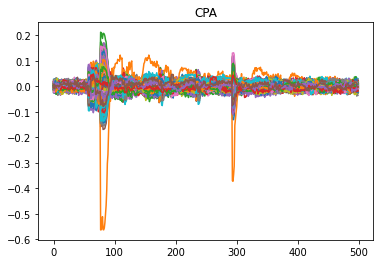

In [25]:
import datasets

# Load a trace. This is our method; not lascars. 
# This trace is:
# - Captured with ChipWhisperer Lite ARM
# - Has no side-channel countermeasures
# - Varies the input while the key is constant
data = datasets.dataset("cw_plain_fixedkey")

trace = lascar.TraceBatchContainer(data["trace"], data["input"])
engine = lascar.CpaEngine(
    name="CPA",
    selection_function=lambda value, guess: lascar.tools.aes.sbox[value[0] ^ guess],
    guess_range=range(256),
)
session = lascar.Session(
    trace,
    engine=engine,
    output_method=lascar.MatPlotLibOutputMethod(engine),
    progressbar=False,
)
session.run()

We can speed up the computation by increasing the batch size:

2022-03-13 10:43:33,187 - lascar.session - INFO - Session Session: 10000 traces, 3 engines, batch_size=100000, leakage_shape=(500,)


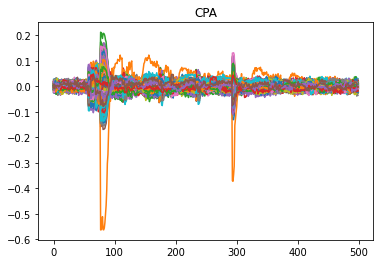

2022-03-13 10:43:35,196 - lascar.session - INFO - Session Session: 10000 traces, 3 engines, batch_size=100, leakage_shape=(500,)


CPU times: user 2.03 s, sys: 1.57 s, total: 3.6 s
Wall time: 2.01 s


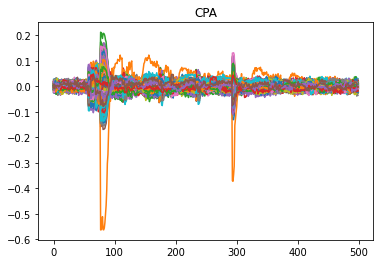

CPU times: user 3.54 s, sys: 5.52 s, total: 9.06 s
Wall time: 2.89 s


In [27]:
%time session.run(batch_size=100)
%time session.run(batch_size=100_000)